In [1]:
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow import keras
#from tensorflow.keras.utils import to_categorical ## specific  one I wanna use
from tensorflow.keras import utils
#from tensorflow.keras.layers import Input, Dense, Dropout  # Specific ones I wanna use, can just import whole module
from tensorflow.keras import layers 
from tensorflow.keras.models import Model
import h5py
#import tables
import matplotlib.pyplot as plt
#import tensorflow as tf
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight


In [2]:
import tensorflow as tf
gpu_available = tf.test.is_gpu_available()
gpu_available

True

In [3]:
x=1
y=3
x+y

4

In [6]:
# Load padded data
with h5py.File('leading_10_arr_3d.h5', 'r') as f:
    padded_arr_3d = f['array'][:]

with h5py.File('4_event_types_labels.h5', 'r') as f:
    df_labels = f['array'][:]
    
with h5py.File('4_event_types_weights.h5', 'r') as f:
    df_weights = f['array'][:]


In [7]:
# Need to take the n leading order jets for my second method
df_labels.shape

(881096,)

In [8]:
X = padded_arr_3d
y = df_labels

print(X.shape)

# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2,
                                                      random_state=10)

input_shape = X_train.shape[2]
print('There are', input_shape, 'variables in this model')
print('The dataset has', len(y), 'processes')


print(X_train.shape)
print(y_train.shape)

(881096, 10, 23)
There are 23 variables in this model
The dataset has 881096 processes
(704876, 10, 23)
(704876,)


In [7]:
#Define the Model

# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=input_shape), 
#     layers.Dense(units=256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate = 0.3), 
#     layers.Dense(units=256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(rate = 0.3),
#     layers.Dense(units=1, activation='sigmoid'),
# ])


# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy'],
# )



In [13]:
# Define a RNN

#input_shape = (None, X_train.shape[2]) # shape of input sequence
input_shape = (10, X_train.shape[2]) # shape of input sequence#

model = keras.Sequential([
    layers.Masking(mask_value=0.0, input_shape=input_shape),
    layers.LSTM(units=64, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3), 
    layers.LSTM(units=64, return_sequences=True),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3), 
    layers.LSTM(units=64),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units=1, activation='sigmoid'),
])

from tensorflow.keras.optimizers import Adam

lr = 0.0005 # specify learning rate
optimizer = Adam(learning_rate=lr)
#model.compile(optimizer=optimizer, loss='categorical_crossentropy')



model.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

model.summary()
#model.get_config()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_1 (Masking)          (None, 10, 23)            0         
_________________________________________________________________
lstm_3 (LSTM)                (None, 10, 64)            22528     
_________________________________________________________________
batch_normalization_3 (Batch (None, 10, 64)            256       
_________________________________________________________________
dropout_3 (Dropout)          (None, 10, 64)            0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 10, 64)            33024     
_________________________________________________________________
batch_normalization_4 (Batch (None, 10, 64)            256       
_________________________________________________________________
dropout_4 (Dropout)          (None, 10, 64)           

In [9]:
# # from https://github.com/savagedavid7/Predicting-Closing-Prices-Using-LTSM-Recurrent-Neural-Network
# # /blob/master/lstm_stock_predictor_closing.ipynb

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout

# # Build the LSTM model. 
# # The return sequences need to be set to True if you are adding additional LSTM layers, but you don't have to do this for the final layer. 
# # Note: The dropouts help prevent overfitting
# # Note: The input shape is the number of time steps and the number of indicators
# # Note: Batching inputs has a different input shape of Samples/TimeSteps/Features

# # Define the LSTM RNN model
# model = Sequential()

# number_units = 3
# dropout_fraction = 0.2

# # Layer 1
# model.add(LSTM(units=number_units, return_sequences=True, input_shape=(X_train.shape[1],1)))
# model.add(Dropout(dropout_fraction))

# # Layer 2
# model.add(LSTM(units=number_units, return_sequences=True))
# model.add(Dropout(dropout_fraction))

# # Layer 3
# model.add(LSTM(units=number_units))
# model.add(Dropout(dropout_fraction))
# # Output Layer
# model.add(Dense(1))

In [14]:
class_weights = compute_class_weight('balanced', np.unique(y_train), y_train)
print(class_weights)


[0.62673917 2.47255507]


In [15]:

X_train.shape
#y_train.shape

(704876, 10, 23)

Train on 704876 samples, validate on 176220 samples
Epoch 1/200
704876/704876 [==============================] - 149s 211us/sample - loss: 0.6510 - binary_accuracy: 0.6069 - val_loss: 0.6078 - val_binary_accuracy: 0.6497
Epoch 2/200
704876/704876 [==============================] - 123s 174us/sample - loss: 0.6138 - binary_accuracy: 0.6355 - val_loss: 0.6038 - val_binary_accuracy: 0.6386
Epoch 3/200
704876/704876 [==============================] - 120s 170us/sample - loss: 0.6099 - binary_accuracy: 0.6409 - val_loss: 0.6019 - val_binary_accuracy: 0.6421
Epoch 4/200
704876/704876 [==============================] - 114s 162us/sample - loss: 0.6080 - binary_accuracy: 0.6454 - val_loss: 0.6027 - val_binary_accuracy: 0.6234
Epoch 5/200
704876/704876 [==============================] - 117s 167us/sample - loss: 0.6067 - binary_accuracy: 0.6473 - val_loss: 0.6004 - val_binary_accuracy: 0.6407
Epoch 6/200
704876/704876 [==============================] - 109s 154us/sample - loss: 0.6060 - binary_

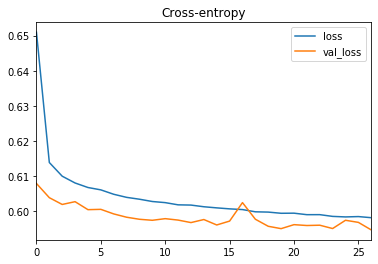

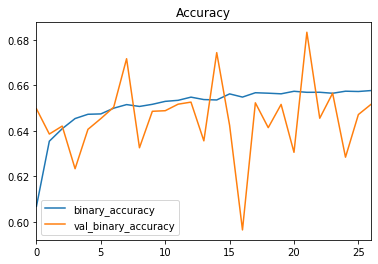

In [16]:
# Train the model, on the full data set

early_stopping = keras.callbacks.EarlyStopping(
    patience=7,
    min_delta=0.001,
    restore_best_weights=True,
)

#class_weight = {0: 1,
 #               1: len(df2)/len(df4)}
    
#ratio = 1/0.27
#class_weight = {0: 0.27 * ratio,
#                1: 0.73 * ratio}

class_weight = {0: class_weights[0], 
               1: class_weights[1]}        # Done by compute_class_weight('balanced', np.unique(y_train), y_train) in cell above


#class_weight = {0: 1, 
 #                1: 2.25} 

    
    
history = model.fit(
    X_train, y_train,
    validation_data=(X_valid, y_valid),
    batch_size=512,  #264,
    epochs=200,
    callbacks=[early_stopping],
    #verbose = 0   #Hide output of epochs
    class_weight = class_weight
)

history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")
history_df = pd.DataFrame(history.history)

print(("Best Validation Loss: {:0.4f}" +\
      "\nBest Validation Accuracy: {:0.4f}")\
      .format(history_df['val_loss'].min(), 
              history_df['val_binary_accuracy'].max()))

model.save('trained_model_10pad2_seed10.h5')

#from tensorflow.keras.models import load_model
#loaded_model = load_model('trained_model.h5')


In [18]:
model.save('trained_model_10pad_RNN1_seed10.h5')


#from tensorflow.keras.models import load_model
#model = load_model('trained_model.h5')


In [14]:
# Found model.evaluate took 383s
# Found model.predict took 
# Should have used timit really

True


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



Validation loss: 0.5997268214933181
Validation accuracy: 0.6526013


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



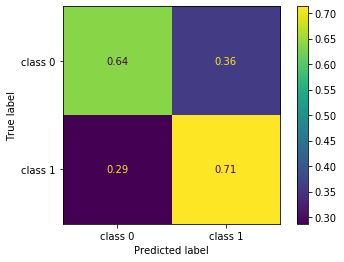

Total signal processes; 1.0
Total background processes; 1.0
305667
There is 142540 signal in the set
The model predicted 163127 more ones than in reality
399209
There is 562336 background in the set
The model predicted -163127 more ones than in reality


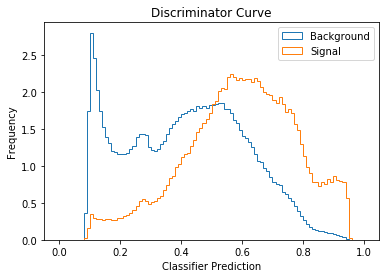

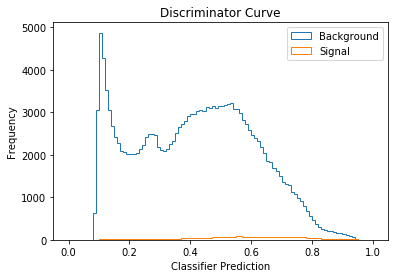

In [19]:
# evaluate the model on the training data, confusion matrix and discriminator curve


gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_train, y_train, verbose = True)    

print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_train, verbose = True)
y_pred_round = np.round(y_pred)
#print(y_pred)

# compute the confusion matrix

cm = confusion_matrix(y_train, y_pred_round, normalize = 'true')   #, normalize = 'true')  #,'true' ‘pred’, ‘all’},)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm) 
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env

disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_train_list = list(y_train)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

data_test = {'True_Val': y_train_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df_test = pd.DataFrame(data_test)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df_test = df_test.sort_values(by='True_Val')
df_test

# Convert arrays to scalars
df_test['Round Prediction'] = df_test['Round Prediction'].apply(lambda x: x[0])
        
pred_one = df_test['Round Prediction'].value_counts()[1.0]
ones_in_set = df_test['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df_test['Round Prediction'].value_counts()[0.0]
zeros_in_set = df_test['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


#Split df into signal and bg

df_bg = df_test[df_test['True_Val'] == 0]
df_signal = df_test[df_test['True_Val'] == 1]

# Make discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred_train = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred_train = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)
    

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised

plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

In [16]:
a = df_weights[:len(lst_of_values_bg_pred_train),1]
print(a)
df_weights

[1.0588149e-06 1.0588149e-06 1.0588149e-06 ... 1.0588149e-06 1.0588149e-06
 1.0588149e-06]


array([[3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       [3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       [3.9628825e-09, 1.0588149e-06, 1.1520365e-06, 8.6958615e-08],
       ...,
       [          nan, 1.0482267e-06,           nan,           nan],
       [          nan, 1.0588149e-06,           nan,           nan],
       [          nan, 1.0588149e-06,           nan,           nan]],
      dtype=float32)

In [30]:
# evaluate the model on the validation data

gpu_available = tf.test.is_gpu_available()
print(gpu_available)   # check still on the gpu

val_loss, val_acc = model.evaluate(X_valid, y_valid, verbose = True)   
print("Validation loss:", val_loss)
print("Validation accuracy:", val_acc)

y_pred = model.predict(X_valid, verbose = True)
y_pred_round = np.round(y_pred)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_round, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

True
34176/1 [==========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

KeyboardInterrupt: 

In [18]:
# #using a permutation method to see what features are important

# # Get the number of features
# n_features = X_valid.shape[1]

# # Initialize an array to store feature importances
# importances = np.zeros(n_features)

# # Calculate the feature importances using the permutation feature importance method
# # Drops each variable one at a time 
# for i in range(n_features):
#     print(i)    #counter to check is working, should go to 40
#     feature_name = X_valid.columns[i]
#     X_permuted = X_valid.copy().values
#     X_permuted[:, i] = np.random.permutation(X_permuted[:, i])
#     y_permuted = model.predict(X_permuted)
#     importances[i] = np.abs(y_permuted - y_pred).mean()
#     #importances[i] = (y_permuted - y_pred).mean()    #try without a abs, see if positively or negatively affected by removal?
#     print(f"Permuted feature {feature_name}")

# # Normalize the feature importances
# importances /= importances.sum()   # importances sum to 1, so can be taken as a literal how important a variable
# # is for the model

# print(importances)  # using abs

# print()#

# print(np.sort(importances))

# # np.random.permutation randomly permutes (rearranges in a random order) the elements.
# # In this case, it is used to shuffle the values in a single column of the X_permuted array.
# # Guess then this variable isnt useful in the prediction

In [19]:
# importances_dict = dict(zip(importances, X_valid.columns))
# # key:value

# #print(combined_dict)

# # get values for keys less than 0.01
# values = []
# for key, value in importances_dict.items():
#     if key < 0.01:
#         values.append(value)

# # print the values
# print(values)


In [20]:
# get indices of numbers less than 0.01
# for i in range(len(importances)):
#     if importances[i] < 0.05:
#         print(X_valid.columns[i])

In [21]:
# Check if order of y_valid is the same order as y_pred
# expect to be the ssame order if accuracy is same as validation accuracy above.

# list of true outcomes
y_valid_list = list(y_valid)

# list of rounded predictions 
y_pred_round_list = list(y_pred_round)

# list of whether these are same    
z=[]
for i in range(len(y_valid_list)):
    if y_valid_list[i]==y_pred_round_list[i]:
        z.append(1)
    else:
        z.append(0)
        
print(sum(z)/len(z))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(z)/len(z) < val_acc + tol)

# If true, suggests are in same order 

0.6516229712858926
True


In [22]:
print(min(y_pred))
max(y_pred)

[0.0805074]


array([0.95167863], dtype=float32)

In [23]:
data = {'True_Val': y_valid_list, 'Predicted': list(y_pred), 'Round Prediction': y_pred_round_list}
df = pd.DataFrame(data)

# Easiest to reorder df, so all 0 (background) are first and then 1's (signal)

#Verified, works
df = df.sort_values(by='True_Val')
df

# Convert arrays to scalars
df['Round Prediction'] = df['Round Prediction'].apply(lambda x: x[0])

In [25]:
#with h5py.File('data_train_10pad_RNN3_SEED10.h5', 'w') as f:
#    f.create_dataset('True_Val', data=df['True_Val'])
#    f.create_dataset('Predicted', data=df['Predicted'])
#    f.create_dataset('Round_Prediction', data=df['Round Prediction'])

    
#with h5py.File('data_test.h5', 'r') as f:
#     true_val = f['True_Val'][:]
#     predicted = f['Predicted'][:]
#     round_pred = f['Round_Prediction'][:]
    
# data_test = {'True_Val': true_val, 'Predicted': predicted, 'Round_Prediction': round_pred}


In [26]:
# Check that they maintained order in the df:

lst=[]
for i in range(len(df)):
    if df['True_Val'][i] == df['Round Prediction'][i]:
        lst.append(1)
    else:
        (lst.append(0))
print(sum(lst)/len(lst))

# Set a tolerance
tol = 0.0001
print(val_acc - tol < sum(lst)/len(lst) < val_acc + tol)

# If true, suggests are in same order 

0.6516229712858926
True


In [27]:
pred_one = df['Round Prediction'].value_counts()[1.0]
ones_in_set = df['True_Val'].value_counts()[1]

# Print the result
print(pred_one)
print('There is', ones_in_set, 'signal in the set')
print('The model predicted',pred_one-ones_in_set ,'more ones than in reality')


pred_zeros = df['Round Prediction'].value_counts()[0.0]
zeros_in_set = df['True_Val'].value_counts()[0]

# Print the result
print(pred_zeros)
print('There is', zeros_in_set, 'background in the set')   #agrees w/ confusion matrix
print('The model predicted', pred_zeros-zeros_in_set,'more ones than in reality')


76213
There is 35318 signal in the set
The model predicted 40895 more ones than in reality
100007
There is 140902 background in the set
The model predicted -40895 more ones than in reality


now first half of df is background, other half is signal

PROBLEM, TEST AND VALID WAS SPLIT RANDOMLY, SO NOT ACTUALLY SAME AMOUNT OF 0's AND 1's

Not a problem, but need to check if should be like this

 A couple of options, I could:

Deal with it, and let there be uneven amounts of 1's and 0's

OR

Go back to test_train_split, and apply individually to signal and background and then sum them?

This would guarantee 50/50


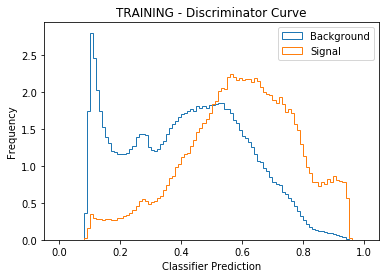

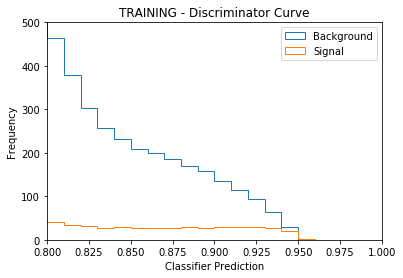

In [28]:
# Training Discriminator curves

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred_train, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised


plt.hist(x= lst_of_values_bg_pred_train, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred_train),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred_train, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred_train),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('TRAINING - Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,500)    # need to zoom in
plt.legend()
plt.show()


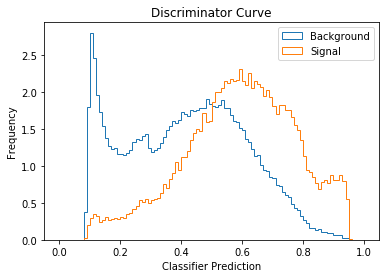

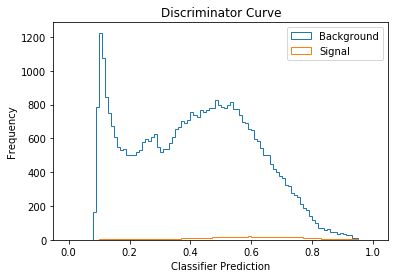

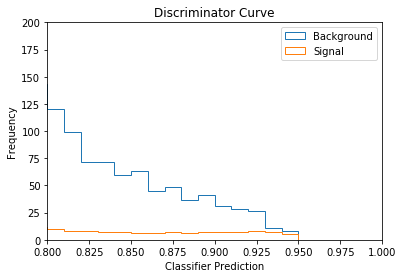

In [29]:
#Split df into signal and bg

df_bg = df[df['True_Val'] == 0]
df_signal = df[df['True_Val'] == 1]

# Make Validation discriminator curves, Histogram

# manipluate data so can be used for Histograms
lst_bg_predicted = []
for i in df_bg['Predicted']:
    lst_bg_predicted.append(i)

lst_of_values_bg_pred = [arr.item() for arr in lst_bg_predicted]

lst_signal_predicted = []
for i in df_signal['Predicted']:
    lst_signal_predicted.append(i)

lst_of_values_signal_pred = [arr.item() for arr in lst_signal_predicted]

binwidth = 0.01
bins=np.arange(0, 1 + binwidth, binwidth)

#Unweighted, normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins, density = True, histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, density = True, histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.legend()
plt.show()

#Weighted to xs_weights x 300000, need to be toproportion of full dataset too
#normalised
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
#plt.xlim(0.9,1)    #zoom in on 0.9 to 1 region
#plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()
    
plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')
plt.title('Discriminator Curve')
plt.xlabel('Classifier Prediction')
plt.ylabel('Frequency')
plt.xlim(0.8,1)    #zoom in on 0.9 to 1 region
plt.ylim(0,200)    # need to zoom in
plt.legend()
plt.show()


#start dropping bins for signifucance part, calc Z and plot, should get curve that peaks

num_bg_events =  43553.808654785156
num_signal_events =  873.333618119359


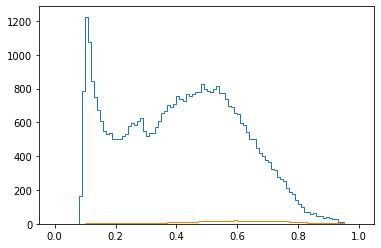

In [31]:
#Calculate number of events

n_bg, bins_bg, patches_bg = plt.hist(x= lst_of_values_bg_pred, bins=bins,  weights = df_weights[:len(lst_of_values_bg_pred),1]*3e5,
         histtype = 'step', label = 'Background')
n_signal, bins_signal, patches_signal = plt.hist(x= lst_of_values_signal_pred, bins=bins, weights = df_weights[:len(lst_of_values_signal_pred),3]*3e5,
         histtype = 'step', label = 'Signal')

# calculate the number of events
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print('num_bg_events = ', num_bg_events)
print('num_signal_events = ', num_signal_events)

In [ ]:
#plot ROC curves

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the false positive rate and true positive rate
fpr, tpr, thresholds = roc_curve(y_true, y_score)

# calculate the area under the ROC curve
roc_auc = auc(fpr, tpr)

# plot the ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

print(roc_auc)  

print(len(thresholds))



<ipython-input-31-7e8139bec9c6>:1: RuntimeWarning: divide by zero encountered in true_divide
  data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
<ipython-input-31-7e8139bec9c6>:1: RuntimeWarning: invalid value encountered in true_divide
  data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}


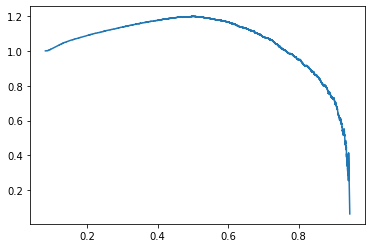

1.198695985076894

In [31]:
data_roc = {'thresholds': thresholds, 'tpr': tpr, 'fpr': fpr, 'tpr/sqrt(fpr)':tpr/np.sqrt(fpr)}
df_roc = pd.DataFrame(data_roc)
#df_roc
df_roc.head(20)
plt.plot(df_roc['thresholds'][3:], df_roc['tpr/sqrt(fpr)'][3:])
plt.show()
max(df_roc['tpr/sqrt(fpr)'][3:])

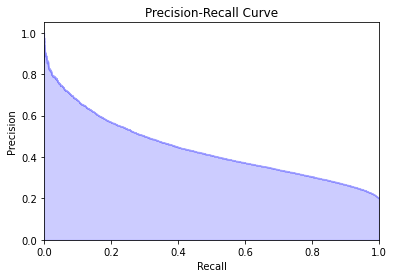

0.44003362290888304


In [32]:
# Plot precision recall curve
from sklearn.metrics import average_precision_score

y_true = df['True_Val']
y_score = df['Predicted']

# calculate the precision-recall curve
precision, recall, _ = precision_recall_curve(y_true, y_score)

# plot the precision-recall curve
plt.step(recall, precision, color='b', alpha=0.2, where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2, color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall Curve')
plt.show()

AUC = average_precision_score(y_true, y_score)   
print(AUC)

In [33]:
df['True_Val']
x = df['Predicted']
print(x)

88109     [0.28111827]
111032    [0.45667157]
111033    [0.18896818]
111034    [0.09857321]
111035    [0.14497054]
              ...     
27764      [0.8310993]
141597     [0.5435255]
27763     [0.83550775]
100490     [0.5316144]
0         [0.56819904]
Name: Predicted, Length: 176220, dtype: object


# Significance

$$ Z = \frac{s}{\sqrt(B+\sigma_s^{2})}  $$

s = number of signal

B = number of background

$\sigma_s$ = statistical uncertainty (~10% of B)

43553.808654785156
873.333618119359


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in double_scalars
  if sys.path[0] == '':
/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


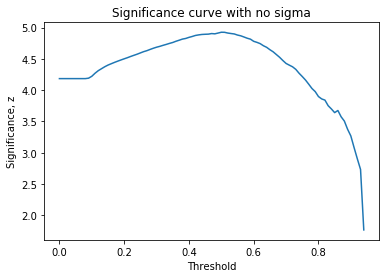

0.5
50
4.925629932190347


/software/deep-learning/envs/ml-microscope/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in less


In [32]:
num_bg_events = np.sum(n_bg)
num_signal_events = np.sum(n_signal)

print(num_bg_events)
print(num_signal_events)

z = np.empty(len(bins_bg))
for i in range(len(bins_bg)):
    num_bg_events = np.sum(n_bg[i:])
    num_signal_events = np.sum(n_signal[i:])
    #print(num_signal_events)
    z_i = num_signal_events / np.sqrt(num_bg_events)
    z[i] = z_i
#print(z)


x = np.linspace(0,1,len(z))
plt.plot(bins_bg,z[:])
#plt.xlim([0, 1.0])
#plt.ylim([0.0, 1.05])
plt.xlabel('Threshold')
plt.ylabel('Significance, z')
plt.title('Significance curve with no sigma')
plt.show()


mask = z < 1e10     #just so doesnt include infs
index_of_max = np.argmax(z[mask])
max_value = np.amax(z[mask])


#index_of_max = np.nanargmax(z[:])
#max_value = np.nanmax(z[:])     # 1 point before last, should probs generalise so that can deal w inf etc 
max_bin = bins_bg[index_of_max]
print(max_bin)
print(index_of_max)
print(max_value)

# significance = sigmna, 6.5 signma, 5 sigma

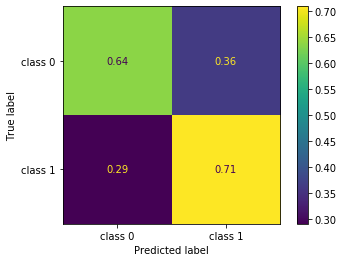

Total signal processes; 1.0
Total background processes; 1.0


In [33]:
# Confusion matricies with new threshold at max significance

# calculates prediction values
#y_pred = model.predict(X_valid) 

significance_threshold = max_bin
y_pred_threshold = np.where(y_pred >= significance_threshold, 1, 0)

# compute the confusion matrix
cm = confusion_matrix(y_valid, y_pred_threshold, normalize = 'true')    #,'true' ‘pred’, ‘all’},)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['class 0', 'class 1']) # other env
#disp = ConfusionMatrixDisplay(confusion_matrix=cm)   
disp.plot()
plt.show()

print('Total signal processes;', cm[1,0]+cm[1,1])
print('Total background processes;', cm[0,0]+cm[0,1])

In [36]:
# See weight is const basically, so just use a value

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
#plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

semi_xs_weight = df2['xs_weight']   # plot to show is wrong, at least 1 -ive val (is this right?)
signal_xs_weight = df4['xs_weight'] 
plt.hist(x=semi_xs_weight, bins = 10, weights = df2.xs_weight, density = True, histtype = 'step', label = 'Background')
#plt.hist(x=signal_xs_weight, bins = 10, weights = df4.xs_weight, density = True, histtype = 'step', label = 'Signal')
plt.title('xs_weight')
plt.legend()
plt.show() 

NameError: name 'df2' is not defined

In [ ]:
#Also, to make sure we get the event weights correct, can each of you try and produce a number for the 
#total number of events you obtain when using all events in the ttH125 and ttbar semileptonic dataframes,
#normalized to 300/fb?
#Hopefully you all arrive at the same result.

# Sligthly confused, does x_s weight normalised already entail no. events,
# So xs_weight * 300,000 is no events

#Or

# Are we meant to use the equation you showed us last week and work out what N should be

#Or

# do both and compare them as should be same?

bg_weight = semi_xs_weight[1]
signal_weight = signal_xs_weight[1]

# total number SL
sl_tot_events = bg_weight * 300000      # weight per pb to 300fb

# total number signal
signal_tot_events = signal_weight * 300000

print('Total number of semileptonic events is {}'.format(sl_tot_events))
print('Total number of ttH125 events is {}'.format(signal_tot_events))
print()

sl_events = 300000 * 500
signal_events = 300000 * 0.5

print('Total number of semileptonic events is {}'.format(sl_events)) #150000k
print('Total number of ttH125 events is {}'.format(signal_events))   #150k
#tot_events = 

# Q 
Can you also overlay the discriminator distributions for the test data 
(normalized to the same area) to check if training and testing samples agree?
# A
not sure what is meant, so show code for the one that I did do. I did it for validation data, so when he says this does hr mean my data is test or training

# Q 
If you use all the events in the dataframes and weight each entry by xs_weight you should
get the expected number of events for 1 /pb. Is everything in the plot below already 
multiplied by 300000 to get the event yields expected for 300/fb?
What exactly did you use?

# A
Yes, everything in the weighted plot is multiplied by 300000, show what I used as I am not sure if thats right

# Q
If you integrate the weighted histograms, how many events do you obtain in each histogram? 

# A
Bit confused, why integrate the histograms when can just see how much data used, is it because this is weighted so it will give the number of events we actually expect overall in 300000 fb^-1, makes sense.
#Did 3 ways, not really clear what was right, way I think rn is each bin is a number of events, so just need to add number events per bin, dont need to do anything regarding the width of the bin? But then an integral is the area so that does mean bin size matters, but not really sure, bc obvs sum bin size = 1
#Think first one is correct


# Q 
Next would be to plot ROC curves and precision-recall which have slightly different meaning.

# A
So does a ROC curve work out where the best threshold is for us, so what is significance. Also should a ROC curve be weighted

# Q 
from the weighted plot, make a plot of Z = S/sqrt(B) as a function of the cut on the discriminator value, where S and B are the number of events (i.e. the integral) of the histogram 
that have discriminator value above the cut you chose. You may need to “zoom in” on the region >0.9 
to see that it falls off again as you approach 1

In [ ]:
print(df1['xs_weight'])
plt.hist(df1['xs_weight'])

In [ ]:
print(df2['xs_weight'])
plt.hist(df2['xs_weight'])

In [ ]:
print(df3['xs_weight'])
plt.hist(df3['xs_weight'])

In [ ]:
print(df4['xs_weight'])
plt.hist(df4['xs_weight'])

In [ ]:
print('TTToHadronic weight: ', df1['xs_weight'][10000])
print('TTToSL weight: ', df2['xs_weight'][0])
print('TTL2NU weight: ', df3['xs_weight'][0])
print('TTH125 weight: ', df4['xs_weight'][0])

# Updates from 08/02 grind
- I trained on full dataset and got like 10% more accuracy, actually a v good now, loss also down a fair bit, 0.1

- But does take like 10 mins to run training data

- Actually, not that good
